In [12]:
from operator import methodcaller

import polars as pl
import numpy as np
import renkon.api as rk

import seaborn as sns
import matplotlib.pyplot as plt

def plot_linreg(m, c, *, ax):
    """ Plot y = mx + c """
    ax = ax or plt.gca()
    x = np.array(ax.get_xlim())
    y = m * x + c
    ax.plot(x, y, color="green", linestyle=":")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cereals_df = pl.read_csv("../etc/samples/cereals.csv", separator=";", skip_rows_after_header=1).with_columns(
    carbs=pl.col("carbo") + pl.col("sugars"),
)
cereals_df

name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating,carbs
str,str,str,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64
"""100% Bran""","""N""","""C""",70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973,11.0
"""100% Natural B…","""Q""","""C""",120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.0,33.983679,16.0
"""All-Bran""","""K""","""C""",70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505,12.0
"""All-Bran with …","""K""","""C""",50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.5,93.704912,8.0
"""Almond Delight…","""R""","""C""",110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843,22.0
"""Apple Cinnamon…","""G""","""C""",110,2,2,180,1.5,10.5,10,70,25,1,1.0,0.75,29.509541,20.5
"""Apple Jacks""","""K""","""C""",110,2,0,125,1.0,11.0,14,30,25,2,1.0,1.0,33.174094,25.0
"""Basic 4""","""G""","""C""",130,3,2,210,2.0,18.0,8,100,25,3,1.33,0.75,37.038562,26.0
"""Bran Chex""","""R""","""C""",90,2,1,200,4.0,15.0,6,125,25,1,1.0,0.67,49.120253,21.0


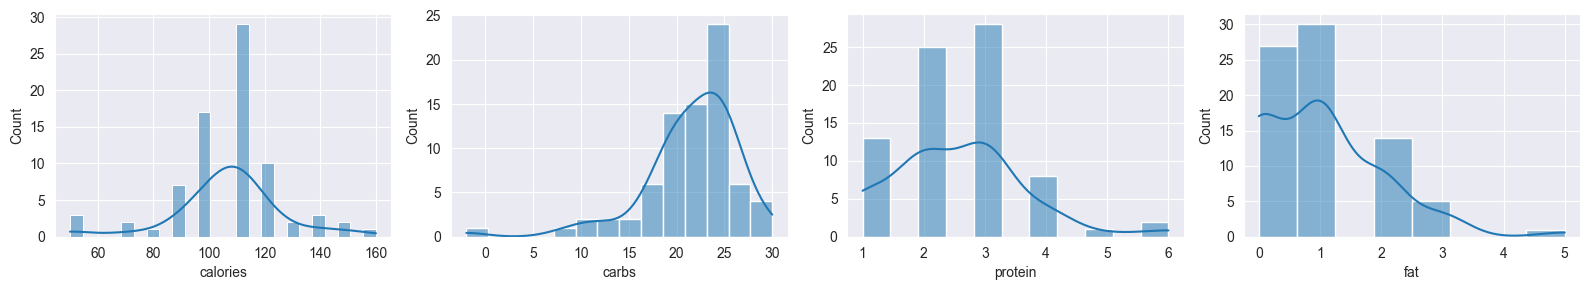

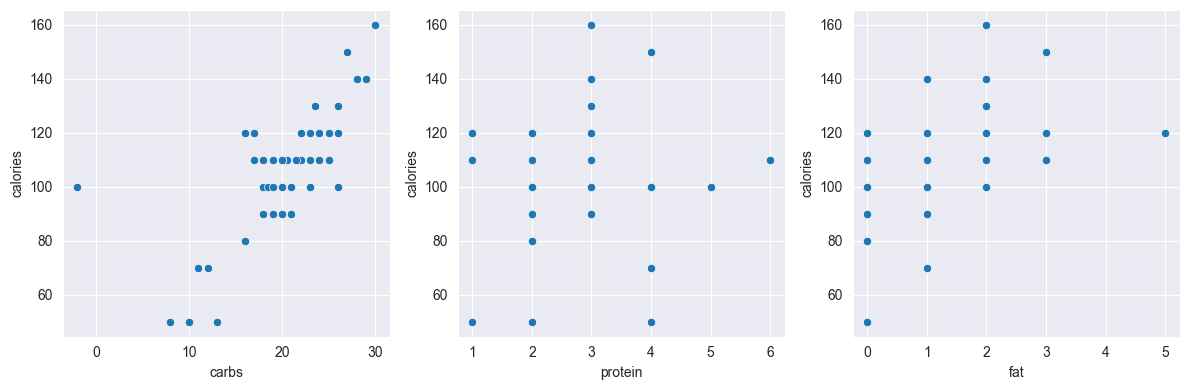

In [17]:
# Data Inspection

fig, axs = plt.subplots(1, 4, figsize=(16, 3))
sns.histplot(ax=axs[0], data=cereals_df, x="calories", kde=True);
sns.histplot(ax=axs[1], data=cereals_df, x="carbs", kde=True);
sns.histplot(ax=axs[2], data=cereals_df, x="protein", kde=True);
sns.histplot(ax=axs[3], data=cereals_df, x="fat", kde=True);
fig.tight_layout()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.scatterplot(ax=axs[0], data=cereals_df, x="carbs", y="calories")
sns.scatterplot(ax=axs[1], data=cereals_df, x="protein", y="calories")
sns.scatterplot(ax=axs[2], data=cereals_df, x="fat", y="calories")
fig.tight_layout()

In [4]:
CALORIES_PER = {
    "carbs": 4,
    "protein": 4,
    "fat": 9,
}

cals_df = cereals_df.select(
    pl.col("name"),
    pl.col("calories").alias("cals_from_label"),
    pl.concat_list("carbs", "protein", "fat").apply(
        methodcaller("dot", CALORIES_PER.values())
    ).alias("cals_from_macros")
)
cals_df

name,cals_from_label,cals_from_macros
str,i64,f64
"""100% Bran""",70,69.0
"""100% Natural B…",120,121.0
"""All-Bran""",70,73.0
"""All-Bran with …",50,48.0
"""Almond Delight…",110,114.0
"""Apple Cinnamon…",110,108.0
"""Apple Jacks""",110,108.0
"""Basic 4""",130,134.0
"""Bran Chex""",90,101.0


In [23]:
model, fit = rk.stats.linear_fit(data=cereals_df, y="calories", x=["carbs", "protein", "fat"])
fit.params

OLSParams(m=array([3.18008835, 4.46475158, 9.13673172]), c=17.82905484599198)

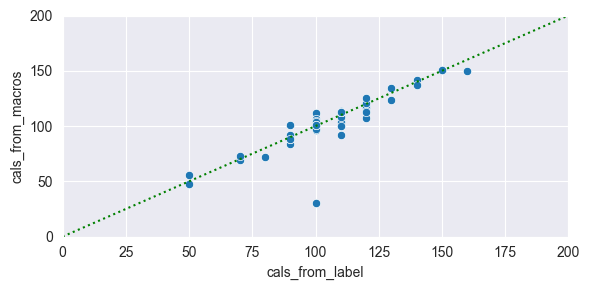

In [19]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.plot([0, 200], [0, 200], color="green", linestyle=":")
sns.scatterplot(ax=ax, data=cals_df, x="cals_from_label", y="cals_from_macros")
fig.tight_layout()

# Model Testing

In [53]:
results_df = cereals_df.select(
    expected=pl.col("calories"), 
    predicted=fit.predict().alias("calories_pred"), 
    err=fit.errors().abs().alias("err"),
    # MAD of calories
    threshold=(pl.col("calories") - pl.col("calories").median()).abs().median()
).with_columns(
    is_outlier=pl.col("err") > pl.col("threshold")
)
results_df

expected,predicted,err,threshold,is_outlier
i64,f64,f64,f64,bool
70,79.805765,9.805765,10.0,false
120,127.788382,7.788382,10.0,false
70,82.985853,12.985853,10.0,true
50,61.128768,11.128768,10.0,true
110,114.993965,4.993965,10.0,false
110,110.223833,0.223833,10.0,false
110,106.260767,3.739233,10.0,false
130,132.17907,2.17907,10.0,false
90,102.677145,12.677145,10.0,true


In [56]:
results_df["is_outlier"].value_counts()

is_outlier,counts
bool,u32
false,68
true,9


In [57]:
results_df.with_row_count().filter(pl.col("is_outlier")).sort("err", descending=True)

row_nr,expected,predicted,err,threshold,is_outlier
u32,i64,f64,f64,f64,bool
57,100,52.0661,47.9339,10.0,true
33,110,94.825077,15.174923,10.0,true
46,160,144.899423,15.100577,10.0,true
54,50,63.634955,13.634955,10.0,true
2,70,82.985853,12.985853,10.0,true
8,90,102.677145,12.677145,10.0,true
41,100,111.203115,11.203115,10.0,true
3,50,61.128768,11.128768,10.0,true
11,110,120.132618,10.132618,10.0,true
